In [1]:
### Imports
import os
import numpy as np
import pandas as pd
import tifffile as tiff
from nd2reader import ND2Reader
from tqdm import tqdm
import btrack
from btrack.constants import BayesianUpdates

In [5]:
# Variables
IMG_DIR = '/mnt/imaging.data/PertzLab/apoDetection/TIFFs'
APO_DIR = '/mnt/imaging.data/PertzLab/apoDetection/ApoptosisAnnotation'

MASK_DIR = '../data/apo_masks'
CSV_DIR = '../data/apo_match_csv'
DF_DIR = '../data/summary_dfs'
CROPS_DIR = '../data/apo_crops'


# Tracking
## Path to btrack config file
BT_CONFIG_FILE: str = "extras/cell_config.json"

## Tracking radius [px]
EPS_TRACK: int = 70

## Minimum track length [frames] (for filtering and passing on to ARCOS)
TRK_MIN_LEN: int = 60

In [21]:
# Load 
def load_image_stack(path):
    """
    Load an image stack from a file based on its extension.
    
    Uses tifffile for TIFF files and ND2Reader for ND2 files.
    """
    if path.endswith(('.tif', '.tiff')):
        # Load TIFF file using tifffile
        return tiff.imread(path)
    elif path.endswith('.nd2'):
        # Load ND2 file using ND2Reader and convert it to a numpy array
        with ND2Reader(path) as nd2:
            return np.array(nd2)
    else:
        raise ValueError(f"Unsupported file format for file: {path}")

def get_image_paths(directory):
    """
    Returns a list of absolute paths of all TIFF and ND2 files in a directory.
    """
    valid_extensions = ('.tif', '.tiff', '.nd2')
    paths = [
        os.path.abspath(os.path.join(directory, f))
        for f in os.listdir(directory)
        if f.endswith(valid_extensions)
    ]
    return sorted(paths)



def crop_window(img, center_x, center_y, window_size):
    # Check if number is even, add one if so
    if window_size%2 == 0:
        window_size += 1
        print(f'Window size even, adding 1.\n\tNew window size: {window_size}')
    half_window_size = window_size // 2
    x_from = max(center_x - half_window_size, 0)
    x_to = min(center_x + half_window_size + 1, img.shape[1])
    y_from = max(center_y - half_window_size, 0)
    y_to = min(center_y + half_window_size + 1, img.shape[0])
    window = img[y_from:y_to, x_from:x_to]

    return window

if not os.path.exists(CSV_DIR):
        os.makedirs(CSV_DIR)  
if not os.path.exists(MASK_DIR):
            os.makedirs(MASK_DIR)
if not os.path.exists(DF_DIR):
            os.makedirs(DF_DIR)
if not os.path.exists(CROPS_DIR):
            os.makedirs(CROPS_DIR)

image_paths = []
image_paths = get_image_paths(os.path.join(IMG_DIR))

### TODO remove :2 here, was only for testing
image_paths = np.array(image_paths).flatten()[:2]
filenames = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]

print(filenames)

for name in filenames:
    if not os.path.exists(os.path.join(CROPS_DIR, name)):
            os.makedirs(os.path.join(CROPS_DIR, name))
    # Load mask file
    mask_path = os.path.join(MASK_DIR, f'{name}.npz')
    with np.load(mask_path) as data:
        labels = data['gt']


    # Load summary df 
    summary_df_path = os.path.join(DF_DIR, f'{name}_pd_df.csv')
    summary_df = pd.read_csv(summary_df_path)

    # Create btrack objects (with properties) from the segmentation data
    # By setting properties=('area',) the tracking algorithm takes into account the mask's area in addition to x/y.
    # By setting assign_class_ID=True adds the object ID that will be used later in merging tracking results with the dfProp table.
    btObj = btrack.utils.segmentation_to_objects(
            labels, properties=("area",), assign_class_ID=True
    )
    _, fovY, fovX = labels.shape
    
    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config JSON file
        tracker.configure(BT_CONFIG_FILE)
        tracker.update_method = BayesianUpdates.APPROXIMATE
        tracker.max_search_radius = EPS_TRACK
    
        # append the objects to be tracked
        tracker.append(btObj)
    
        # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
        tracker.volume = ((0, fovX), (0, fovY))
    
        # track them (in interactive mode)
        tracker.track_interactive(step_size=100)
    
        # generate hypotheses and run the global optimizer
        tracker.optimize()
    
        # get the tracks as a python list
        btTracks = tracker.tracks


    dfBTracks = pd.concat(pd.DataFrame(t.to_dict(["ID", "t", "x", "y"])) for t in btTracks)

    dfBTracks.rename(
        columns={
            "ID": "track_id",
            "t": "t",
            "x": "x",
            "y": "y",
            "class_id": "obj_id"
        }, inplace = True
    )

    dfBTracks["obj_id"] = dfBTracks["obj_id"].astype("Int32")

    merged_df = summary_df.merge(dfBTracks.drop(columns=["x", "y", "area"]), on=["obj_id", "t"], how="left")
    merged_df_long = merged_df[merged_df.groupby("track_id")["track_id"].transform('size') >= TRK_MIN_LEN]

    # Load images to extract windows
    imgs = load_image_stack(os.path.join(IMG_DIR, f'{name}.tif'))

    # Load csv with manual apo annotations and new stardist centroids
    apo_file = os.path.join(CSV_DIR, f'{name}.csv')
    apo_annotations = pd.read_csv(apo_file, header=0)

    for i, row in apo_annotations.iterrows():
        current_object = row.loc['matching_object']
        current_t = row.loc['t']
        #print(current_object, current_t)
        current_track_id = merged_df.loc[
                (merged_df['obj_id'] == current_object) & 
                (merged_df['t'] == current_t), 
                'track_id'
            ].squeeze()
        #current_track_id = current_track_id.iloc[0]
        #print(current_track_id)
    
        single_cell_df = merged_df_long.loc[(merged_df_long['track_id'] == current_track_id) & (merged_df_long['t'] >= current_t)]
        windows = []
        ### TODO: put to variables
        WINDOW_SIZE = 61
        target_size = WINDOW_SIZE if WINDOW_SIZE%2 != 0 else WINDOW_SIZE + 1
        for _, row in single_cell_df.iterrows():
            window = crop_window(imgs[row['t']], row['x'], row['y'], WINDOW_SIZE)
            if window.shape == (target_size, target_size):
                windows.append(window)

        if windows:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, name, f'trackID_{current_track_id}.tif'), windows)
        else:
            print('No valid windows found.')
        


#os.path.join(DF_DIR, f'{filename}_pd_df.csv')
#tiff.imwrite('output.tif', arr)

['Exp01_Site01', 'Exp01_Site02']


[INFO][2025/03/07 06:55:02 PM] Localizing objects from segmentation...
100%|████████████████████████████████████████████████████████████████████████████████| 1441/1441 [01:50<00:00, 13.07it/s]
[INFO][2025/03/07 06:56:52 PM] Objects are of type: <class 'dict'>
[INFO][2025/03/07 06:56:56 PM] ...Found 612856 objects in 1441 frames.
[INFO][2025/03/07 06:56:56 PM] Loaded btrack: /home/nbahou/miniforge3/envs/ERK_gpu/lib/python3.10/site-packages/btrack/libs/libtracker.so
[INFO][2025/03/07 06:56:56 PM] Starting BayesianTracker session
[INFO][2025/03/07 06:56:56 PM] Loading configuration file: extras/cell_config.json
[INFO][2025/03/07 06:56:56 PM] Objects are of type: <class 'list'>
[WARNING][2025/03/07 06:56:56 PM] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2025/03/07 06:56:56 PM] Starting tracking... 
[INFO][2025/03/07 06:56:56 PM] Update using: ['MOTION']
[INFO][2025/03/07 06:56:57 PM] Tracking objects in frames 0 to 99 (of 1441)...
[INFO][2025/03/07 06:56:57 PM]  - 

GLPK Integer Optimizer 5.0
29796 rows, 28305 columns, 42923 non-zeros
28305 integer variables, all of which are binary
Preprocessing...
14898 rows, 28305 columns, 42923 non-zeros
28305 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14898
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14898 rows, 28305 columns, 42923 non-zeros
*     0: obj =   8.451693242e+04 inf =   0.000e+00 (10678)
Perturbing LP to avoid stalling [511]...
*  8969: obj =   2.817663055e+04 inf =   2.000e-09 (1409) 5
Removing LP perturbation [10417]...
* 10417: obj =   2.708178225e+04 inf =   0.000e+00 (0) 4
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+ 10417: mip =     not found yet >=              -inf        (1; 0)
+ 10438: >>>>>   2.709167410e+04 >=   2.708690811e+04 < 0.1% (16; 0)
+ 10477: mip = 

[INFO][2025/03/07 06:57:13 PM] Completed optimization with 4929 tracks
[INFO][2025/03/07 06:57:14 PM] Ending BayesianTracker session


window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shap

[INFO][2025/03/07 06:57:23 PM] Localizing objects from segmentation...
100%|████████████████████████████████████████████████████████████████████████████████| 1441/1441 [01:45<00:00, 13.64it/s]
[INFO][2025/03/07 06:59:08 PM] Objects are of type: <class 'dict'>
[INFO][2025/03/07 06:59:12 PM] ...Found 566748 objects in 1441 frames.
[INFO][2025/03/07 06:59:12 PM] Loaded btrack: /home/nbahou/miniforge3/envs/ERK_gpu/lib/python3.10/site-packages/btrack/libs/libtracker.so
[INFO][2025/03/07 06:59:12 PM] Starting BayesianTracker session
[INFO][2025/03/07 06:59:12 PM] Loading configuration file: extras/cell_config.json
[INFO][2025/03/07 06:59:12 PM] Objects are of type: <class 'list'>
[WARNING][2025/03/07 06:59:13 PM] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2025/03/07 06:59:13 PM] Starting tracking... 
[INFO][2025/03/07 06:59:13 PM] Update using: ['MOTION']
[INFO][2025/03/07 06:59:13 PM] Tracking objects in frames 0 to 99 (of 1441)...
[INFO][2025/03/07 06:59:14 PM]  - 

GLPK Integer Optimizer 5.0
22416 rows, 20738 columns, 31011 non-zeros
20738 integer variables, all of which are binary
Preprocessing...
11208 rows, 20738 columns, 31011 non-zeros
20738 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 11208
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
11208 rows, 20738 columns, 31011 non-zeros
*     0: obj =   5.898442483e+04 inf =   0.000e+00 (7433)
Perturbing LP to avoid stalling [557]...
Removing LP perturbation [7305]...
*  7305: obj =   1.977132116e+04 inf =   1.332e-15 (0) 5
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  7305: mip =     not found yet >=              -inf        (1; 0)
+  7318: >>>>>   1.978664682e+04 >=   1.977801456e+04 < 0.1% (13; 0)
+  7362: mip =   1.978664682e+04 >=     tree is empty   0.0% (0; 45)
INTEGER 

[INFO][2025/03/07 06:59:25 PM] Completed optimization with 3870 tracks
[INFO][2025/03/07 06:59:26 PM] Ending BayesianTracker session


window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 61)
window shape: (61, 53)
window shape: (61, 55)
window shape: (61, 55)
window shape: (61, 55)
window shape: (61, 57)
window shape: (61, 61)
window shape: (61, 59)
window shap

In [20]:
WINDOW_SIZE%2

1

In [18]:
window.shape 

(61, 61)

In [19]:
(target_size, target_size)

(62, 62)

In [11]:
windows = np.asarray(windows)
windows.shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (99, 60) + inhomogeneous part.

In [67]:
print(merged_df.head())

row = apo_annotations.iloc[1]
current_object = row['matching_object']
current_t = row['t']
print(current_object)
print(current_t)
current_track_id = merged_df.loc[
                (merged_df['obj_id'] == current_object) & 
                (merged_df['t'] == current_t), 
                'track_id'
            ].squeeze()
print(current_track_id)



   obj_id  t    x    y  track_id
0       1  0  462  784     168.0
1       2  0  852  816     159.0
2       3  0   78  116     292.0
3       4  0  420  452     311.0
4       5  0   94  342     366.0
113
426
nan


In [77]:
print(merged_df.loc[(merged_df['obj_id'] == 337) & (merged_df['t'] == 219)])

       obj_id    t   x    y  track_id
93908     337  219  88  742        38


In [16]:
# Convert btrack output to pandas
print(merged_df.shape)
print(merged_df_long.shape)


(566748, 5)
(549101, 5)


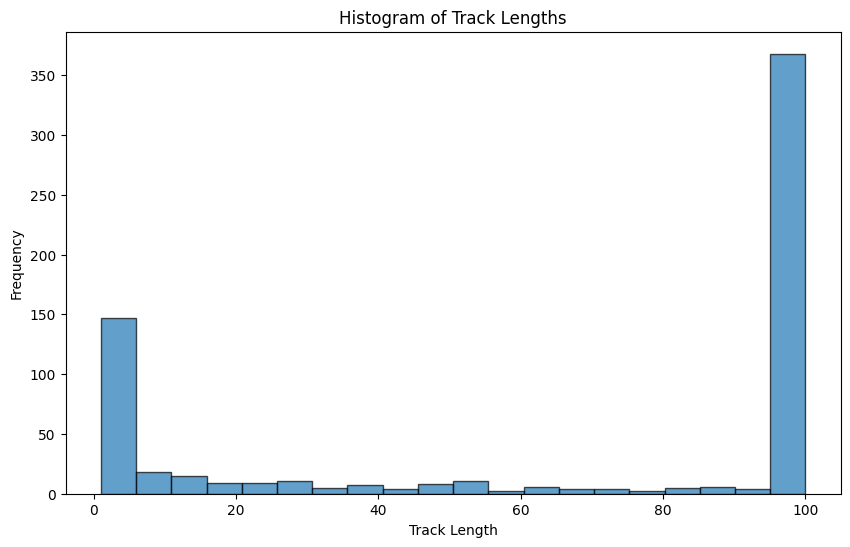

In [73]:
import matplotlib.pyplot as plt

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()


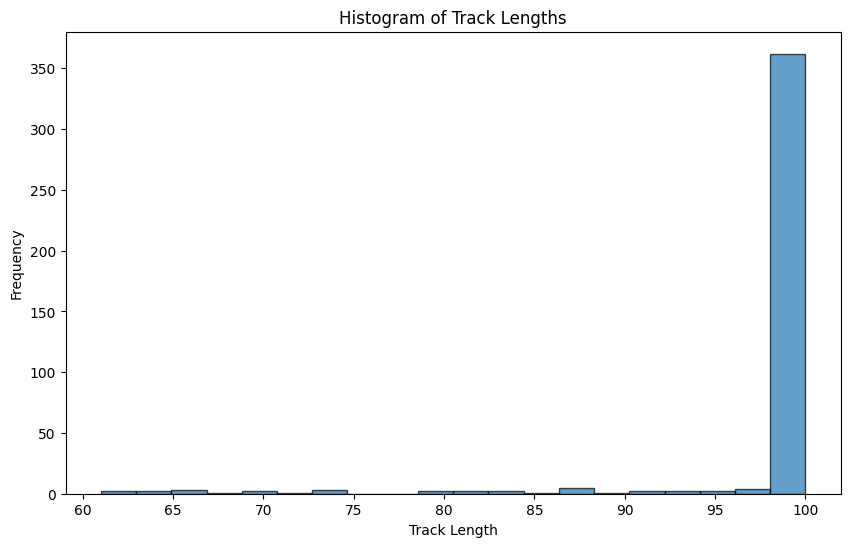

In [74]:
import matplotlib.pyplot as plt

# Count occurrences of each track_id to determine track lengths
track_lengths = merged_df_long["track_id"].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=20, edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Track Length")
plt.ylabel("Frequency")
plt.title("Histogram of Track Lengths")

# Show plot
plt.show()

In [63]:
### Now we can match apoptotic cells to tracks --> extract all t after apoptosis annotation for window cropping
def crop_window(img, center_x, center_y, window_size):
    # Check if number is even, add one if so
    if window_size%2 == 0:
        window_size += 1
        print(f'Window size even, adding 1.\n\tNew window size: {window_size}')
    half_window_size = window_size // 2
    x_from = max(center_x - half_window_size, 0)
    x_to = min(center_x + half_window_size, img.shape[0])
    y_from = max(center_y - half_window_size, 0)
    y_to = min(center_y + half_window_size, img.shape[0])
    window = img[y_from:y_to, x_from:x_to]

    return window

# Load csv with manual apo annotations and new stardist centroids
apo_file = os.path.join(CSV_DIR, f'{filenames[1]}.csv')
apo_annotations = pd.read_csv(apo_file, header=0)

print(apo_annotations.head())

for _, row in apo_annotations.iterrows():
    current_object = row['matching_object']
    current_t = row['t']
    current_track_id = merged_df_long.loc[(merged_df_long['obj_id'] == current_object) & (merged_df_long['t'] == current_t), 'track_id'].squeeze()
    print(current_track_id)

    single_cell_df = merged_df_long.loc[(merged_df_long['track_id'] == current_track_id) & (merged_df_long['t'] >= current_t)]

    

    print(single_cell_df)
    

    #print(summary_df[(summary_df['obj_id'] == current_object) & (summary_df['t'] == current_t)])
    
    #print(row['matching_object'])

        filename    x    y    t  matching_object  strdst_x  strdst_y
0  series_2.tif   314  192  268              205       314       190
1  series_2.tif    20   60  426              113        22        52
2  series_2.tif   563    1  242              339       554         8
3  series_2.tif   636  369  290              165       634       370
4  series_2.tif   938  203  273              141       932       208
Series([], Name: track_id, dtype: float64)


ValueError: Can only compare identically-labeled Series objects

In [ ]:
# Column names in single-cell timeseries from segmentation
COL_POS: list = ["x", "y"]
COL_FRAME: str = "t"
COL_RT: str = "rt"
COL_OBJ_ID: str = "obj_id"
COL_TRK_ID: str = "track_id"
COL_MEAS: str = "cnr"

# column name with collective event track ids
COL_COLL_ID: str = "cl_id"



## Values for measurement clipping and interpolation
ACQ_FREQ: int = 5
INTERPOLATE: bool = False
CLIP: bool = False
CLIP_LOW: float = 0.001
CLIP_HIGH: float = 0.999

In [ ]:
# Create btrack objects (with properties) from the segmentation data
# By setting properties=('area',) the tracking algorithm takes into account the mask's area in addition to x/y.
# By setting assign_class_ID=True adds the object ID that will be used later in merging tracking results with the dfProp table.
h2b_btObj = btrack.utils.segmentation_to_objects(
        h2b_y_val_pred, properties=("area",), assign_class_ID=True
)
erk_btObj = btrack.utils.segmentation_to_objects(
        erk_y_val_pred, properties=("area",), assign_class_ID=True
)

In [ ]:
# Initialise a tracker session using a context manager
glpk_options = {
    'tm_lim': 240000  # Time limit in milliseconds (2 minutes)
}
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config JSON file
    tracker.configure(BT_CONFIG_FILE)

    tracker.update_method = BayesianUpdates.APPROXIMATE
    tracker.max_search_radius = EPS_TRACK

    # append the objects to be tracked
    tracker.append(h2b_btObj)

    # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
    tracker.volume = ((0, fovX), (0, fovY))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    # get the tracks as a python list
    h2b_btTracks = tracker.tracks

    # optional: get the data in a format for napari
    #btData, btProperties, btGraph = tracker.to_napari()
